In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy

from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

import os
from scipy.io import savemat
import argparse

%load_ext autoreload
%autoreload 2

/home/manuelf/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:277: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
from dust3r.utils.image import load_images
import copy

outdir = "./output"
device = "cuda:1"
#device = "cpu"
#im_dir = "./images_in/pda"
#im_dir = "./images_in/train"
im_dir = "./images_in/DAVIS/JPEGImages/480p/train"

#make filelist be a list of all the files in the directory
#filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
#print(filelist)

#load images

imgs = load_images(im_dir, size=512, verbose=1, skip_frames=8, ground_truth=True)
filelist = [img["path"] for img in imgs]

if len(imgs) == 1:
        imgs = [imgs[0], copy.deepcopy(imgs[0])]
        imgs[1]['idx'] = 1
        filelist = [im_dir[0], im_dir[0] + '_2']
        

imgs[0].keys()

>> Loading images from ./images_in/DAVIS/JPEGImages/480p/train
 - adding 00000.jpg with resolution 854x480 --> 512x288
 - adding 00009.jpg with resolution 854x480 --> 512x288
 - adding 00018.jpg with resolution 854x480 --> 512x288
 - adding 00027.jpg with resolution 854x480 --> 512x288
 - adding 00036.jpg with resolution 854x480 --> 512x288
 - adding 00045.jpg with resolution 854x480 --> 512x288
 - adding 00054.jpg with resolution 854x480 --> 512x288
 - adding 00063.jpg with resolution 854x480 --> 512x288
 - adding 00072.jpg with resolution 854x480 --> 512x288
 (Found 9 images)


dict_keys(['img', 'true_shape', 'idx', 'instance', 'path', 'gt'])

In [3]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth


/home/manuelf/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


len of pairs 30


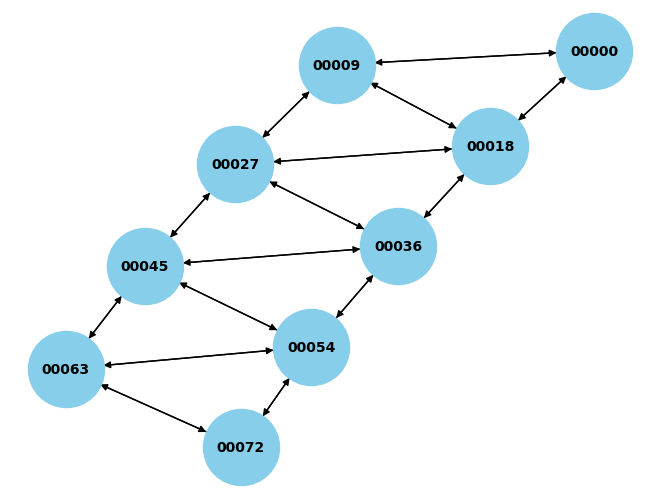

In [13]:
#test make_pairs
from dust3r.image_pairs import make_pairs
from auxiliar.viz_graph import viz_graph

#scenegraphy
scenegraph_type="swin"
win_cyclic = False
winsize = 2
refid = 0

scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)

print("len of pairs", len(pairs))

file_names = [im["path"] for im in imgs]

viz_graph(file_names, pairs)

In [ ]:
from auxiliar.scene_to_data import SceneToData
import time

# cache to store previous inference results
delete_cache = True
if delete_cache:
    os.system(f"rm -rf {outdir}/cache")
cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# optimization level
optim_level = "coarse"
niter2 = 0 if optim_level == "coarse" else 200

scene, _, res_coarse, res_fine = sparse_global_alignment(filelist, pairs, cache_dir,
                                    model, lr1=0.07 , niter1=500, lr2=0.014, niter2=niter2, device=device,
                                    opt_depth='depth' in optim_level, shared_intrinsics=False,
                                    matching_conf_thr=0.5)

#save the scene into mat files and full pcd file with 0wrld pts
scene_class = SceneToData(scene)
scene_class.save_mat_file(outdir)
scene_class.save_pcd_file(outdir, conf_threshold=0.001)

100%|████████████████████████| 72/72 [00:20<00:00,  3.54it/s]


Inference time: 7.79s, Correspondences time: 11.37s


100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 12.04it/s]


init focals = [360.00278 366.87067 370.14722 368.44513 367.51724 362.32373 362.1396
 366.45538 378.14618]


100%|██████████████| 500/500 [00:20<00:00, 24.35it/s, lr=0.0000, loss=0.165]


>> final loss = 0.1647568643093109
Final focals = [360.00278 366.87067 370.14722 368.44513 367.51724 362.32373 362.1396
 366.45538 378.14618]
Optimization took 20.54051160812378 s


In [5]:
# dust3r ga + mast3r model
from dust3r.inference import inference
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode


for pair in pairs:
    continue
    pair[0]["img"][0,:,torch.tensor(pair[0]["gt"]).to(torch.bool)] = 0
    pair[1]["img"][0,:,torch.tensor(pair[1]["gt"]).to(torch.bool)] = 0

output = inference(pairs, model, device, batch_size=1, verbose=True)

>> Inference with model on 30 image pairs


  0%|                                                                                                                                                                                                                  | 0/30 [00:00<?, ?it/s]/home/manuelf/mast3r/dust3r/dust3r/inference.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/manuelf/mast3r/dust3r/dust3r/model.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/manuelf/mast3r/dust3r/dust3r/inference.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████████████████████████████████████████████████████████████████████████████████

# just check what is the output of just one pair

### Non symmetric inference, just one branch of the network without the cross-attention

In [6]:
import matplotlib.pyplot as plt
from pypcd4 import PointCloud
from auxiliar.motion_mask import find_mask
from tqdm import tqdm
import copy
import cv2 as cv

new_output = copy.deepcopy(output)

# delete all images in test_images folder
os.system("rm test_images/*")

# load co-tracker model
cotracker = None
if 'cotracker' not in globals():
    cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)

if "raft" not in globals():
    raft = torch.hub.load('pytorch/vision:v0.15.2', 'raft_large', pretrained=True).to(device)
    raft = raft.eval()

grid_size = 45
epipolarReproj = 1.0
raft_model = raft 
model="homography"
use_GT = True

# encode just one image
with torch.no_grad():

    idx = 0
    for pair in tqdm(pairs):

        if not use_GT:
            mask_out_0 = find_mask(cotracker, device, pair[0], pair[1], grid_size=grid_size,
                                epipolarReproj=epipolarReproj,raft_model=raft, model=model) # image , height x width
            mask_out_1 = find_mask(cotracker, device, pair[1], pair[0], grid_size=grid_size,
                                epipolarReproj=epipolarReproj, raft_model=raft, model=model) # image , height x width
        else: # use ground trith masks
            mask_out_0 = 1-pair[0]["gt"]
            mask_out_1 = 1-pair[1]["gt"]

            
        new_output["pred1"]["conf"][idx, ~torch.tensor(mask_out_0).to(torch.bool)] = 1.0
        new_output["pred2"]["conf"][idx, ~torch.tensor(mask_out_1).to(torch.bool)] = 1.0

        new_output["pred1"]["pts3d"][idx, ~torch.tensor(np.repeat(np.expand_dims(mask_out_0,axis=2),3,axis=2)).to(torch.bool)] = 0.0
        new_output["pred2"]["pts3d_in_other_view"][idx, ~torch.tensor(np.repeat(np.expand_dims(mask_out_1,axis=2),3,axis=2)).to(torch.bool)] = 0.0


        #im = (new_output["pred2"]["conf"][idx,:,:].cpu().numpy() - \
        #    np.min(new_output["pred2"]["conf"][idx,:,:].cpu().numpy())) * (255/np.max(new_output["pred2"]["conf"][idx,:,:].cpu().numpy()))
        
        cv.imwrite(f'test_images/conf_mask_{pair[0]["instance"]}_{pair[1]["instance"]}.png', \
                   cv.cvtColor(mask_out_1.astype(np.uint8), cv.COLOR_GRAY2BGR)*100 + cv.cvtColor(pair[1]["img"].squeeze().permute(1,2,0).cpu().numpy()/2 + 0.5, cv.COLOR_BGR2RGB)* 255 / 2 )

        idx += 1


Using cache found in /home/manuelf/.cache/torch/hub/pytorch_vision_v0.15.2
/home/manuelf/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/manuelf/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.86it/s]


In [9]:
from dust3r.cloud_opt.base_opt import clean_pointcloud
from dust3r.utils.geometry import inv

mode = GlobalAlignerMode.PointCloudOptimizer if len(imgs) > 2 else GlobalAlignerMode.PairViewer
scene = global_aligner(new_output, device=device, mode=mode, verbose=True)

loss = scene.compute_global_alignment(init='mst', niter=150, schedule="cosine", lr=0.01)

# better confs
cleaned_confs = clean_pointcloud(scene.get_conf(), scene.get_intrinsics(), inv(scene.get_im_poses()), scene.get_conf(), scene.get_pts3d())

 init edge (8*,6*) score=16.104726791381836
 init edge (6,4*) score=15.784679412841797
 init edge (4,2*) score=8.68779468536377
 init edge (7*,8) score=8.321024894714355
 init edge (7,5*) score=7.878624439239502
 init edge (0*,2) score=6.310304641723633
 init edge (5,3*) score=9.55069637298584
 init edge (1*,3) score=4.211580276489258
 init loss = 0.07100215554237366
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:09<00:00, 15.36it/s, lr=2.09647e-06 loss=0.0448239]


In [10]:
scene.im_poses

Parameter containing:
tensor([[ 1.9856e-03, -1.0362e-01, -3.8219e-02,  1.0261e+00, -3.0440e-01,
          1.1405e-01, -1.0695e-01],
        [ 1.3257e-02, -8.5519e-02, -2.1877e-02,  1.0319e+00, -2.8905e-01,
          1.3419e-01, -1.1802e-01],
        [-4.7480e-03, -6.6363e-02, -1.0064e-02,  1.0179e+00, -2.5806e-01,
          9.6995e-02, -1.1307e-01],
        [-2.0034e-02, -6.3361e-02,  2.3015e-03,  1.0158e+00, -2.2247e-01,
          6.7052e-02, -9.8445e-02],
        [-1.8989e-02, -2.6293e-02,  4.9236e-03,  1.0658e+00, -2.0749e-01,
          6.1631e-02, -1.0419e-01],
        [-3.7616e-02, -2.6443e-02,  5.0083e-03,  1.0491e+00, -1.5498e-01,
          7.3786e-04, -8.8417e-02],
        [-2.2961e-02,  8.3555e-04,  1.6527e-02,  1.1218e+00, -1.0638e-01,
          2.1219e-02, -4.7716e-02],
        [ 8.8582e-03, -1.6353e-02,  1.6601e-02,  1.0822e+00, -2.8800e-02,
          6.3092e-02, -4.8571e-02],
        [-4.6346e-03, -4.3156e-03,  4.2742e-03,  1.2911e+00,  0.0000e+00,
          0.0000e+00,  0

In [14]:
from scipy.spatial.transform import Rotation as R
import rerun as rr
from auxiliar.rerun import log_points, log_camera_pose
import time

# Initialize Rerun logging
rr.init("3D Points and Camera Visualization")

cam_poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
colors = [im["img"].squeeze().permute(1,2,0).reshape(-1, 3).detach().cpu().numpy() for im in imgs]
focals = scene.get_focals()
depthmaps = scene.get_depthmaps()

scale_rerun_w = 1.0
rr.notebook_show(width=int(1920*scale_rerun_w), height=int(1080*scale_rerun_w))

conf_thresh = 0.5

# load all 3d points and colors
cat_3d_wrld = np.concatenate([pts3d[timestamp].detach().cpu().numpy().reshape(-1, 3)[(cleaned_confs[timestamp].detach().cpu().reshape(-1,1)>conf_thresh).squeeze(),:] \
                              for timestamp in range(0, cam_poses.shape[0])])
cat_3d_clr = np.concatenate([((colors[timestamp][(cleaned_confs[timestamp].detach().cpu().reshape(-1,1)>conf_thresh).squeeze(),:]+1)/2*255).astype(np.uint32).tolist()\
                              for timestamp in range(0, cam_poses.shape[0])])

# downsample points
cat_3d_wrld = cat_3d_wrld[::5]
cat_3d_clr = cat_3d_clr[::5]

rr.log("world/3d", rr.Points3D(cat_3d_wrld, colors =cat_3d_clr))


# update all transforms over the timestamps
for timestamp in range(0, cam_poses.shape[0]):

    # wrld to camera TF
    rr.log("world/camera", rr.Transform3D(translation=cam_poses[timestamp][:3, 3].detach().cpu().numpy(), \
                                          rotation=rr.Quaternion(xyzw=R.from_matrix(cam_poses[timestamp][:3, :3].detach().cpu()).as_quat())))
    
    # pinhole definition
    rr.log("world/camera", rr.Pinhole(width=imgs[timestamp]["img"].shape[3], height=imgs[timestamp]["img"].shape[2], focal_length=float(focals[timestamp].detach().cpu().numpy().squeeze())))

    # image in the pinhole
    rr.log("world/camera/rgb", rr.Image((imgs[timestamp]["img"].detach().cpu().squeeze().permute(1,2,0).numpy()+1)/2))

    # log depthmaps with confidence
    rr.log("world/camera/depth", rr.DepthImage(depthmaps[timestamp].detach().cpu().numpy()))
    


Viewer()

In [28]:
from dust3r.post_process import estimate_focal_knowing_depth 
import cv2 as cv
from tqdm import tqdm

# estimate focal lenght for each pair and the pairwise transformation

idx_pair = 0
tfs = {}

for idx_pair, pair in tqdm(enumerate(pairs)):

    #print("between img", pair[0]["instance"], pair[1]["instance"])
    H, W = torch.tensor(pair[0]["img"].shape[2:] )
    pp = torch.tensor([W / 2, H / 2]).to(device)

    focal_length = estimate_focal_knowing_depth(output["pred1"]["pts3d"][idx_pair,:,:,:].unsqueeze(0).to(device) * scene.get_pw_scale()[idx_pair],\
                                                 pp, focal_mode='weiszfeld')

    K = np.eye(3)
    K[0, 0] = focal_length
    K[1, 1] = focal_length
    K[0, 2] = pp[0]
    K[1, 2] = pp[1]

    K = scene.get_intrinsics()[int(pair[1]["instance"])].detach().cpu().numpy()

    #solve the pnp
    pixels = np.mgrid[:int(W), :int(H)].T.astype(np.float32)
    status, R, T, inliers = cv.solvePnPRansac( output["pred1"]["pts3d"][idx_pair,:,:,:].numpy().reshape(-1, 3) * scene.get_pw_scale()[idx_pair].detach().cpu().numpy(), \
                                                pixels.reshape(-1,2), K, None, flags=cv.SOLVEPNP_EPNP)
    
    rot_mat = cv.Rodrigues(R)[0]
    t_vec = T

    if pair[0]["instance"] not in tfs:
        tfs[pair[0]["instance"]] = {}

    tfs[pair[0]["instance"]][pair[1]["instance"]] = np.vstack(( np.hstack((rot_mat, t_vec)), np.array([0, 0, 0, 1]) ))
    
    idx_pair += 1


0it [00:00, ?it/s]

30it [00:03,  8.52it/s]


In [35]:
focal_length
scene.get_focals()[-1]

tensor([336.7113], device='cuda:1', grad_fn=<SelectBackward0>)

In [42]:
scene.get_pts3d()

[tensor([[[-2.0663, -0.5241,  1.3217],
          [-2.0439, -0.5179,  1.3082],
          [-2.0412, -0.5192,  1.3112],
          ...,
          [ 0.5370, -0.7259,  1.8637],
          [ 0.5409, -0.7250,  1.8619],
          [ 0.5492, -0.7284,  1.8700]],
 
         [[-2.0747, -0.5222,  1.3291],
          [-2.0146, -0.5019,  1.2839],
          [-2.0130, -0.5036,  1.2878],
          ...,
          [ 0.5442, -0.7270,  1.8788],
          [ 0.5351, -0.7140,  1.8484],
          [ 0.5528, -0.7261,  1.8770]],
 
         [[-1.9927, -0.4866,  1.2607],
          [-2.0075, -0.4943,  1.2783],
          [-2.0173, -0.5002,  1.2917],
          ...,
          [ 0.5493, -0.7262,  1.8893],
          [ 0.5471, -0.7197,  1.8741],
          [ 0.5474, -0.7155,  1.8645]],
 
         ...,
 
         [[-1.0334,  0.4761,  0.5012],
          [-1.0304,  0.4755,  0.5008],
          [-1.0301,  0.4764,  0.5030],
          ...,
          [ 0.0442,  0.3789,  0.6826],
          [ 0.0478,  0.3797,  0.6860],
          [ 0.0505

In [30]:
ratio = []
for idx_pair, pw_pose in enumerate(scene.get_pw_poses()):
    norm3r = np.linalg.norm(pw_pose[:3, -1].detach().cpu())
    #print(pairs[idx_pair][0]["instance"], pairs[idx_pair][1]["instance"])
    print("translation distance pw_pose * pw_scale", norm3r)

    norm_pnp = np.linalg.norm(tfs[pairs[idx_pair][0]["instance"]][pairs[idx_pair][1]["instance"]][:3, -1])
    print("translation distance pnp", norm_pnp)

    ratio.append( (norm3r - norm_pnp))
    break

#plt.hist(ratio)


translation distance pw_pose * pw_scale 0.48233378
translation distance pnp 0.054857555789699475


In [21]:
scene.get_pw_scale()[idx_pair]

tensor(0.4903, device='cuda:1', grad_fn=<SelectBackward0>)

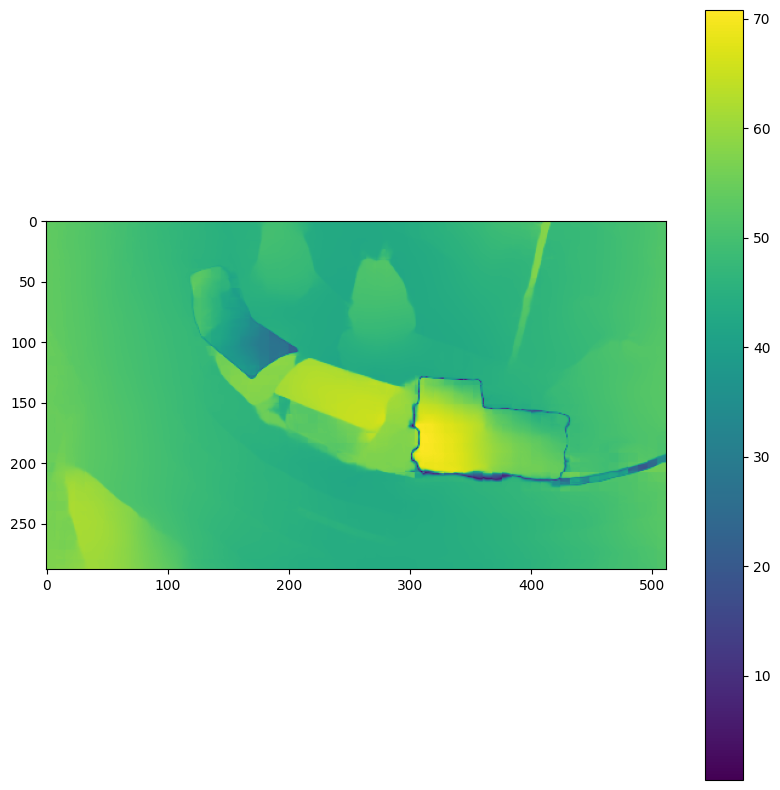

In [20]:
id1 = 0
id2 = 2
mag_threshold = 1
flow = raft_model(imgs[id1]["img"].to(device), imgs[id2]["img"].to(device))[-1]
H, W = torch.tensor(imgs[id1]["img"].shape[2:] )

flow_mag = torch.norm(flow, dim=1, keepdim=True).detach().cpu().numpy().squeeze().squeeze()

pts1 = np.mgrid[:int(W), :int(H)].T.astype(np.float32)

pts2 = pts1 + flow.detach().squeeze().permute(1,2,0).cpu().numpy()

pts1 = pts1.reshape(-1, 2)
pts2 = pts2.reshape(-1, 2)

plt.figure(figsize=(10,10))
#plt.scatter(pts2[(flow_mag>mag_threshold).squeeze(),0], -pts2[(flow_mag>mag_threshold).squeeze(),1], c=flow_mag[(flow_mag>mag_threshold).squeeze()],s=0.01)
plt.imshow(flow_mag)
plt.colorbar()

#set axis equal 
plt.gca().set_aspect('equal', adjustable='box')


In [139]:
#plt.hist(flow_mag, bins=100)
pts2[(flow_mag>8).squeeze(),0].shape

(39370,)

In [14]:
pts3d_masked = scene.get_pts3d()

pts = np.concatenate([p[m].detach().cpu().numpy() for p, m in zip(pts3d_masked, scene.get_masks())])

np.savetxt(f"depth.txt", pts)


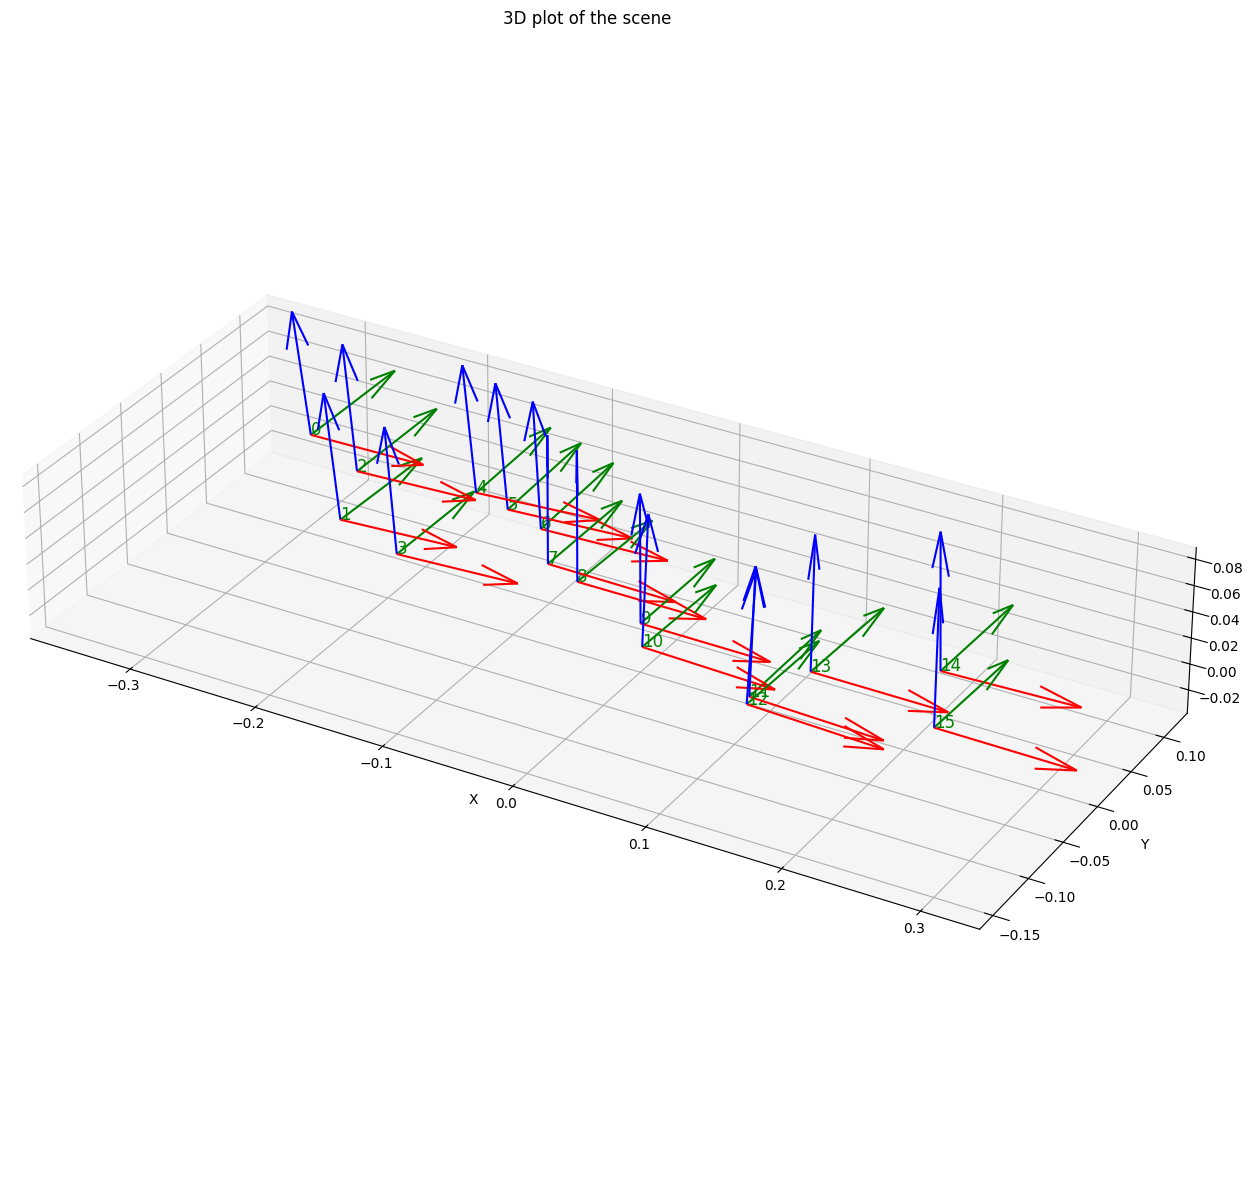

In [240]:
def plot_frame(ax, H, label, scale=0.02, color = 'k'):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=scale, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=scale, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=scale, normalize=True)
    ax.text(*origin, label, fontsize=12, color=color)

poses = scene.get_im_poses().cpu()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for id in range(0, poses.shape[0]):

    pose = poses[id, : , :].detach().cpu().numpy()
    
    plot_frame(ax, pose, str(id), scale=0.1, color='g')

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D plot of the scene')
plt.show()